In [1]:
import arviz as az
import numpyro
from numpyro.infer import Predictive, log_likelihood
import jax
import jax.random as random
import jax.numpy as jnp
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Add ../code to PYTHON_PATH
sys.path.insert(0, "../code")
import bnns.model_configs
from bnns.rasmus_bnn import LATENT
from datasets.synthetic import SyntheticDataset
from datasets.uci import UCIDataset, dataset_names, load_standard_splits
from utils import normalize, check_test_normed

/home/rasmuslovstad/Programs/assignments/thesis/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'utils' is not defined

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
# Adjust as needed
#SAMPLE_PATH = "../samples/2025-03-11T11:57:19.838834" # Golden standar (Ola)
SAMPLE_PATH = "../samples/2025-03-18T12:14:59.598382" # My version
SAMPLE_PATH = SAMPLE_PATH + "/HMC"
SEED = 10

# Load models

In [3]:
models = []
key = jax.random.PRNGKey(SEED)
dataset_keys = jax.random.split(key, len(os.listdir(SAMPLE_PATH)))
for key, dataset_name in zip(dataset_keys, os.listdir(SAMPLE_PATH)):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    model_keys = jax.random.split(key, len(os.listdir(os.path.join(SAMPLE_PATH, dataset_name))))
    if dataset_name in dataset_names:
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))):
            if file_name[-3:] == ".nc":
                model_key = key
                model_name = "_".join(file_name.split("_")[:-1])
                model = bnns.model_configs.__dict__[model_name]
                split_ind = int(file_name.split("_")[-1].split(".")[0])
                print(file_name)
                az_data = az.from_netcdf(os.path.join(SAMPLE_PATH, dataset_name, file_name))
                samples = az_data.to_dict()["posterior"]
                y_loc = samples.pop("y_loc", None)
                models.append({"dataset": dataset_name, "model": model_name, "split": split_ind, "az_data": az_data, "samples": samples, "y_loc": y_loc})
print(f"Loaded {len(models)} models")

UCI_Full_FFT_CBNN_50_0.nc
UCI_Full_FFT_CBNN_50_1.nc
UCI_Full_FFT_CBNN_50_10.nc
UCI_Full_FFT_CBNN_50_11.nc
UCI_Full_FFT_CBNN_50_12.nc
UCI_Full_FFT_CBNN_50_13.nc
UCI_Full_FFT_CBNN_50_14.nc
UCI_Full_FFT_CBNN_50_15.nc
UCI_Full_FFT_CBNN_50_16.nc
UCI_Full_FFT_CBNN_50_17.nc
UCI_Full_FFT_CBNN_50_18.nc
UCI_Full_FFT_CBNN_50_19.nc
UCI_Full_FFT_CBNN_50_2.nc
UCI_Full_FFT_CBNN_50_3.nc
UCI_Full_FFT_CBNN_50_4.nc
UCI_Full_FFT_CBNN_50_5.nc
UCI_Full_FFT_CBNN_50_6.nc
UCI_Full_FFT_CBNN_50_7.nc
UCI_Full_FFT_CBNN_50_8.nc
UCI_Full_FFT_CBNN_50_9.nc
UCI_Full_Spectral_BNN_50_0.nc
UCI_Full_Spectral_BNN_50_1.nc
UCI_Full_Spectral_BNN_50_10.nc
UCI_Full_Spectral_BNN_50_11.nc
UCI_Full_Spectral_BNN_50_12.nc
UCI_Full_Spectral_BNN_50_13.nc
UCI_Full_Spectral_BNN_50_14.nc
UCI_Full_Spectral_BNN_50_15.nc
UCI_Full_Spectral_BNN_50_16.nc
UCI_Full_Spectral_BNN_50_17.nc
UCI_Full_Spectral_BNN_50_18.nc
UCI_Full_Spectral_BNN_50_19.nc
UCI_Full_Spectral_BNN_50_2.nc
UCI_Full_Spectral_BNN_50_3.nc
UCI_Full_Spectral_BNN_50_4.nc
UCI_Full_S

# Load models from Ola's code

In [53]:
import dill
models = []
key = jax.random.PRNGKey(SEED)
dataset_keys = jax.random.split(key, len(os.listdir(SAMPLE_PATH)))
for key, dataset_name in zip(dataset_keys, os.listdir(SAMPLE_PATH)):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    model_keys = jax.random.split(key, len(os.listdir(os.path.join(SAMPLE_PATH, dataset_name))))
    if dataset_name in dataset_names:
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))):
            if file_name[-5:] == ".dill":
                model_key = key
                model_name = "_".join(file_name.split("_")[:-1])
                model = bnns.model_configs.__dict__[model_name]
                split_ind = int(file_name.split("_")[-1].split(".")[0])
                with open(os.path.join(SAMPLE_PATH, dataset_name, file_name), "rb") as f:
                    model_info = dill.load(f)
                samples = model_info["post_draws"]
                samples.pop("y_loc", None)
                models.append({"dataset": dataset_name, "model": model_name, "split": split_ind, "samples": samples})
print(f"Loaded {len(models)} models")

Loaded 2 models


In [40]:
print("Shapes of my version: ")
print(models[0]["samples"]["b0"].shape)
print(models[0]["samples"]["b1"].shape)
print(models[0]["samples"]["b2"].shape)
print(models[0]["samples"]["prec"].shape)
print(models[0]["samples"]["w0"].shape)
print(models[0]["samples"]["w1"].shape)
print(models[0]["samples"]["w2"].shape)
print(train_split.shape)
print(test_split.shape)

Shapes of my version: 
(1, 3000, 50)
(1, 3000, 50)
(1, 3000, 1)
(1, 3000)
(1, 3000, 13, 50)
(1, 3000, 50, 50)
(1, 3000, 50, 1)
(409,)
(51,)


In [44]:
print("Shapes of Ola's version: ")
print(models[0]["samples"]["b0"].shape)
print(models[0]["samples"]["b1"].shape)
print(models[0]["samples"]["b2"].shape)
print(models[0]["samples"]["prec"].shape)
print(models[0]["samples"]["w0"].shape)
print(models[0]["samples"]["w1"].shape)
print(models[0]["samples"]["w2"].shape)
print(train_split.shape)
print(test_split.shape)

Shapes of Ola's version: 
(1, 3000, 50)
(1, 3000, 50)
(1, 3000, 1)
(1, 3000)
(1, 3000, 13, 50)
(1, 3000, 50, 50)
(1, 3000, 50, 1)
(409,)
(51,)


In [52]:
models[0]["samples"]["y_loc"].shape

(1, 3000, 455)

# Compute Negative-Log-Likelihood, RMSE
To compare with Stein paper, Table 2

In [4]:
# From Stein paper, probably more stable but should be equivalent
def nll_reg_fn(posterior_samples, model, x, y, batch_ndims):
    lls = log_likelihood(model, posterior_samples, X=x, y=y, batch_ndims=batch_ndims)["y"]
    return -(jax.scipy.special.logsumexp(lls, axis=0) - jnp.log(lls.shape[0])).mean()

In [10]:
table = [{"dataset": x["dataset"], "model": x["model"], "split": x["split"]} for x in models]
for row, d in zip(models, table):
    dataset = UCIDataset(d["dataset"])
    splits = load_standard_splits(True)[d["dataset"]]
    samples = row["samples"].copy()

    # Important: Squeeze out the redundant chain dimension
    for key in samples:
        assert samples[key].shape[0] == 1
        samples[key] = samples[key][0]

    model = bnns.model_configs.__dict__[row["model"]]
    train_split = splits[d["split"]]["tr"]
    test_split = splits[d["split"]]["te"]

    #X = dataset.normalize_X(dataset.data[:, :-1], splits[d["split"]])
    X = dataset.X
    train_X, mean_X, std_X = normalize(X[train_split], None, None)

    assert train_X.mean().item() < 1e-5
    assert train_X.std().item() - 1.0 < 1e-5
    train_y = dataset.y[train_split]
    test_X, _, _ = normalize(X[test_split], mean_X, std_X)
    test_y = dataset.y[test_split]
    check_test_normed(train_X)

    # train_X = X[train_split]
    # train_y = y[train_split]
    # test_X = X[test_split]
    # test_y = y[test_split]

    train_nll = -log_likelihood(model, samples, X=train_X, y=train_y.flatten(), batch_ndims=1)["y"]
    # print(test_X.shape, test_y.shape)
    test_nll = -log_likelihood(model, samples, X=test_X, y=test_y.flatten(), batch_ndims=1)["y"]

    predictive = Predictive(model, posterior_samples=samples, return_sites=["y_loc"], batch_ndims=1)
    # print(samples.keys())
    predicted_ys = predictive(model_key, X=train_X, y=None, D_Y=1)["y_loc"]
    train_rmse = jnp.sqrt(((train_y - predicted_ys[0])**2).mean())

    predictive = Predictive(model, posterior_samples=samples, return_sites=["y_loc"], batch_ndims=1)
    predicted_ys = predictive(model_key, X=test_X, y=None, D_Y=1)["y_loc"]
    test_rmse = jnp.sqrt(((test_y - predicted_ys[0])**2).mean())

    #d["train_nll"] = train_nll.mean()
    LATENT = list(row["samples"].keys())
    nll_post_samples = Predictive(model, posterior_samples=samples, return_sites=LATENT, batch_ndims=1)(random.PRNGKey(42), X=train_X, y=None, D_Y=1)
    assert jnp.allclose(nll_post_samples["b0"][:5], samples["b0"][:5])
    d["train_nll"] = nll_reg_fn(nll_post_samples, model, train_X, train_y, 1)
    nll_post_samples = Predictive(model, posterior_samples=samples, return_sites=LATENT, batch_ndims=1)(random.PRNGKey(42), X=test_X, y=None, D_Y=1)
    d["test_nll"] = nll_reg_fn(nll_post_samples, model, test_X, test_y, 1)
    d["train_rmse"] = train_rmse.item()
    d["test_rmse"] = test_rmse.item()
table_df = pd.DataFrame(table)
table_df

,dataset,model,split,train_nll,test_nll,train_rmse,test_rmse
0,boston-housing,UCI_Full_FFT_CBNN_50,0,1.7515862,2.2620203,1.538645,2.789203
1,boston-housing,UCI_Full_FFT_CBNN_50,1,1.6581798,2.3372912,1.714849,2.835714
2,boston-housing,UCI_Full_FFT_CBNN_50,10,1.7524723,2.6882498,2.028515,4.149699
3,boston-housing,UCI_Full_FFT_CBNN_50,11,1.8254266,1.9467814,1.787331,2.262863
4,boston-housing,UCI_Full_FFT_CBNN_50,12,1.7209779,2.1111457,1.723708,2.672131
5,boston-housing,UCI_Full_FFT_CBNN_50,13,1.7821233,2.1648362,1.845004,2.884936
6,boston-housing,UCI_Full_FFT_CBNN_50,14,1.8566543,2.1384134,2.066492,2.933993
7,boston-housing,UCI_Full_FFT_CBNN_50,15,1.8894945,2.0946345,1.972997,2.409726
8,boston-housing,UCI_Full_FFT_CBNN_50,16,1.7413542,2.4050663,1.609315,3.096614
9,boston-housing,UCI_Full_FFT_CBNN_50,17,1.739517,2.2628617,1.855169,3.095369


dict_keys(['b0', 'b1', 'b2', 'prec', 'w0', 'w1', 'w2'])

In [13]:
grouped = table_df.groupby(["dataset", "model"]).mean()
stds =  table_df.groupby(["dataset", "model"]).std()[["train_nll", "test_nll", "train_rmse", "test_rmse"]].round(1)
grouped[["train_nll", "test_nll"]] = grouped[["train_nll", "test_nll"]].astype(float).round(1)
grouped[["train_nll", "test_nll", "train_rmse", "test_rmse"]] = grouped[["train_nll", "test_nll", "train_rmse", "test_rmse"]].round(1).astype(str) + "±" + stds.astype(str)
grouped["split"] = table_df.groupby(["dataset", "model"]).count()["split"]
#grouped["target_test_nll"] = ["2.2±0.2", "2.2±0.2","2.7±0.3", "2.7±0.3", "0.5±1.5", "0.5±1.5"]
#grouped["target_test_rmse"] = ["3.6±0.7","3.6±0.7", "4.7±0.6","4.7±0.6", "0.3±0.1", "0.3±0.1"]
grouped[["split", "train_nll", "test_nll", "train_rmse", "test_rmse"]]

split train_nll test_nll train_rmse  \
dataset        model                                                           
boston-housing UCI_Full_FFT_CBNN_50         20   1.8±0.1  2.3±0.2    1.9±0.2   
               UCI_Full_Spectral_BNN_50     20   2.0±0.1  2.3±0.2    2.2±0.3   
concrete       UCI_Full_FFT_CBNN_50          8   2.5±0.0  3.0±0.2    3.5±0.2   

                                        test_rmse  
dataset        model                               
boston-housing UCI_Full_FFT_CBNN_50       3.2±0.7  
               UCI_Full_Spectral_BNN_50   3.4±1.3  
concrete       UCI_Full_FFT_CBNN_50       5.5±0.6

# ArviZ posterior predictive check

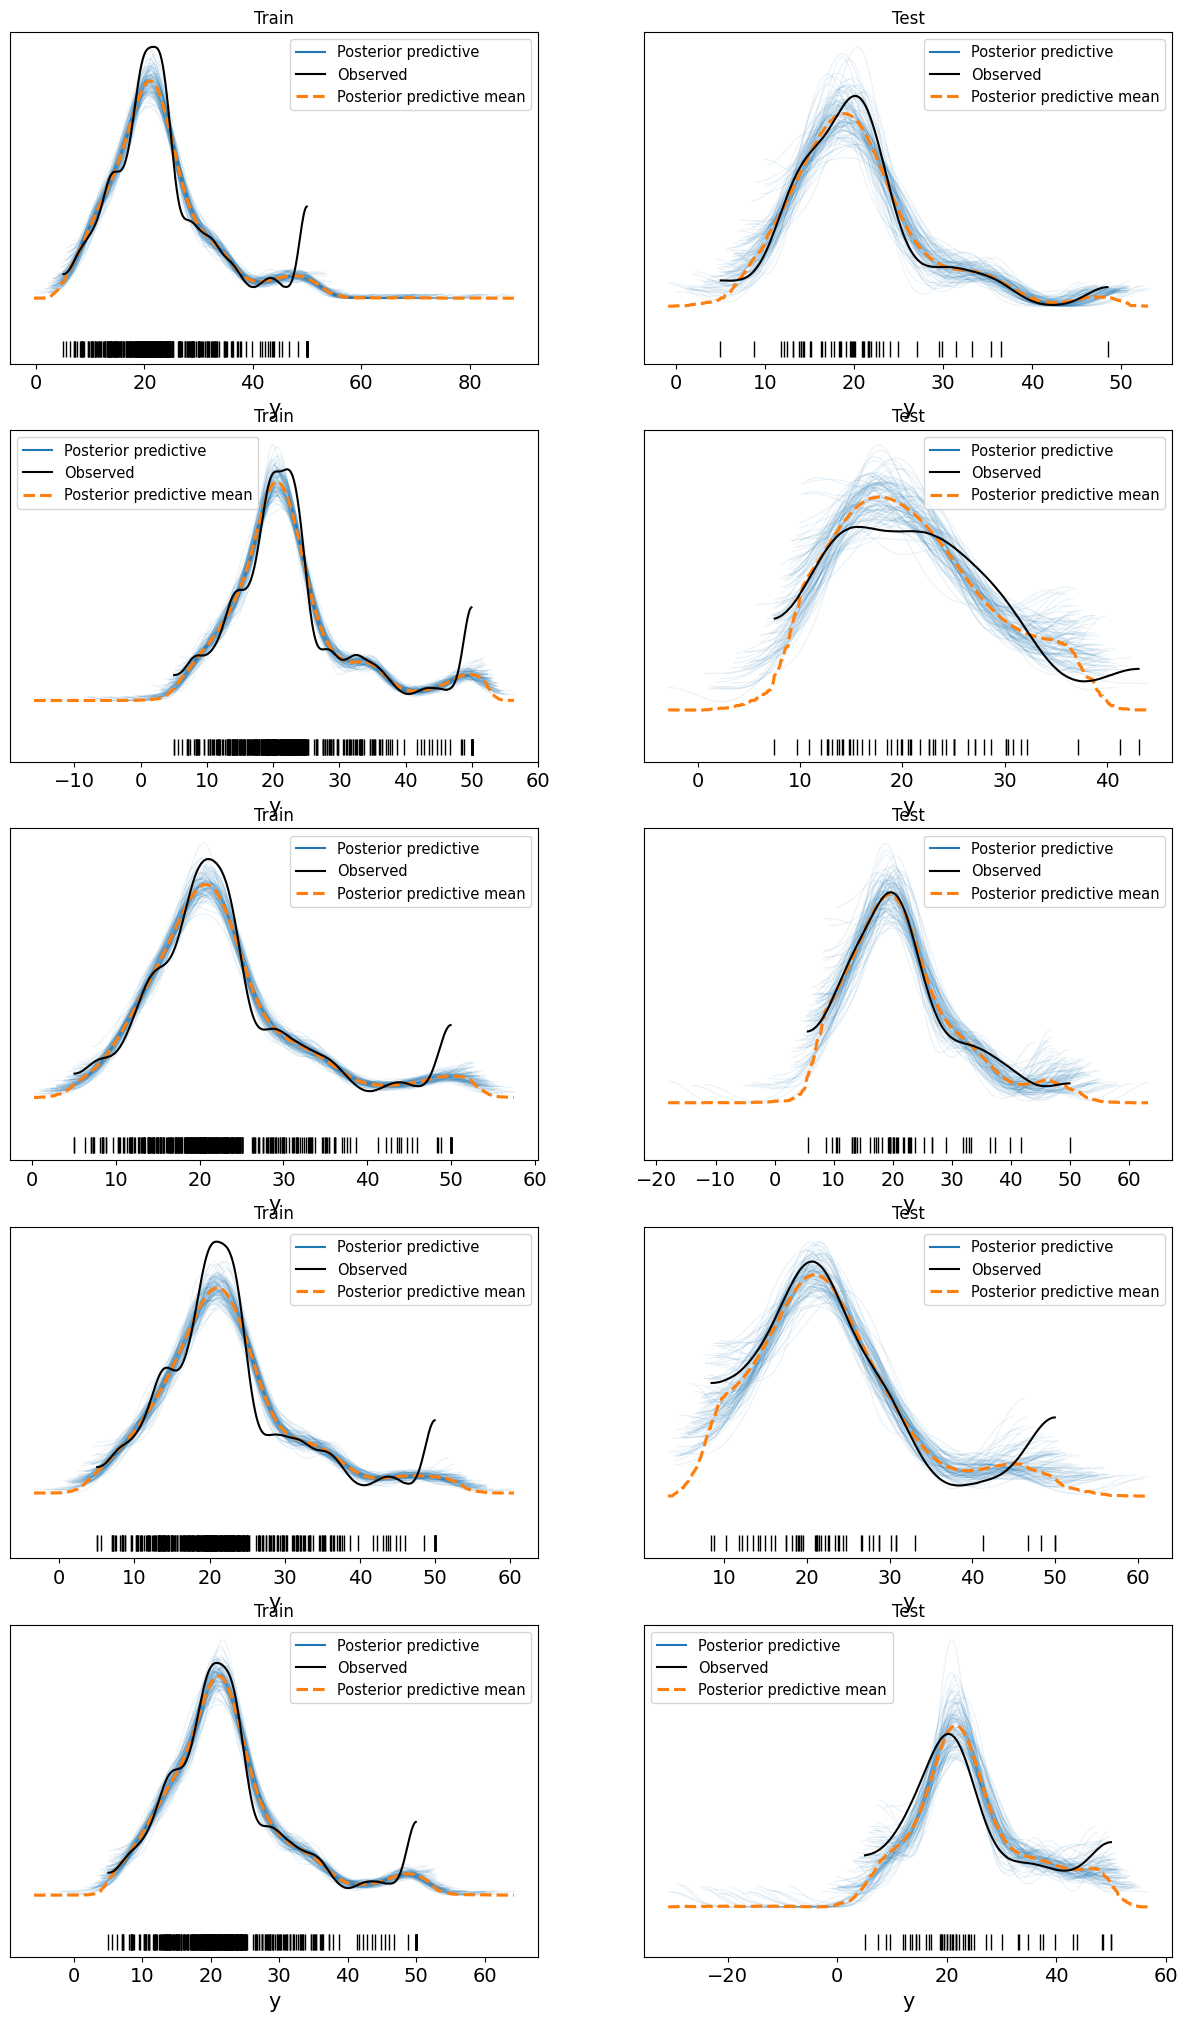

In [16]:
key = jax.random.PRNGKey(SEED)
keys = jax.random.split(key, (len(models), 2))
fig, axs = plt.subplots(len(models), 2, figsize=(15, 5*len(models)))
axs = np.array([axs]) if len(models) == 1 else axs
for (key_tr, key_te), d, row in zip(keys, models, range(len(models))):
    model = bnns.model_configs.__dict__[d["model"]]
    predictive = Predictive(model, posterior_samples=d["samples"], return_sites=["y"], batch_ndims=2, parallel=True)
    dataset = UCIDataset(d["dataset"])
    split = load_standard_splits(True)[d["dataset"]][d["split"]]

    X = dataset.normalize_X(dataset.data[:, :-1], splits[d["split"]])
    y = dataset.data[:, -1]

    train_X = X[split["tr"]]
    train_y = y[split["tr"]]
    test_X = X[split["te"]]
    test_y = y[split["te"]]
    predictive_ys = predictive(key_tr, X=train_X, y=None, D_Y=1)["y"]
    az_data = az.from_dict(posterior_samples=d["az_data"].posterior, constant_data={"X": train_X}, posterior_predictive={"y": predictive_ys}, observed_data={"y": train_y})
    az.plot_ppc(az_data, data_pairs={"y": "y"}, ax=axs[row, 0], kind="kde", observed_rug=True, alpha=0.1)
    axs[row,0].set_title("Train")

    predictive_ys = predictive(key_te, X=test_X, y=None, D_Y=1)["y"]
    az_data = az.from_dict(posterior_samples=d["az_data"].posterior, constant_data={"X": test_X}, posterior_predictive={"y": predictive_ys}, observed_data={"y": test_y})
    az.plot_ppc(az_data, data_pairs={"y": "y"}, ax=axs[row, 1], kind="kde", observed_rug=True, alpha=0.1)
    axs[row,1].set_title("Test")
    

# Plot similar to NumPyro SteinVI example

DATASET: boston-housing, SPLIT: 0, NLL: 3.273998498916626, RMSE: 2.4718074798583984
DATASET: boston-housing, SPLIT: 1, NLL: 4.902329921722412, RMSE: 2.5874125957489014
DATASET: boston-housing, SPLIT: 2, NLL: 3.8312854766845703, RMSE: 2.4223153591156006
DATASET: boston-housing, SPLIT: 3, NLL: 3.164726972579956, RMSE: 2.1815860271453857
DATASET: boston-housing, SPLIT: 4, NLL: 10.538721084594727, RMSE: 4.416593074798584


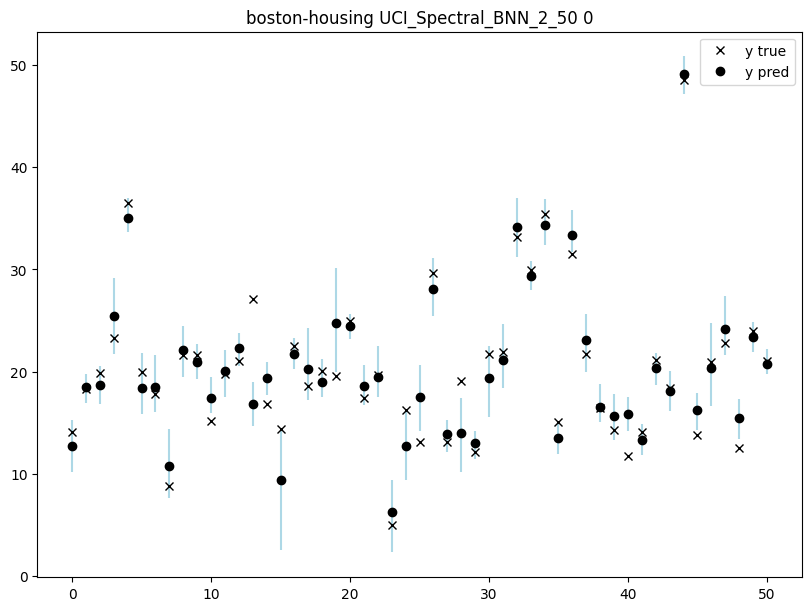

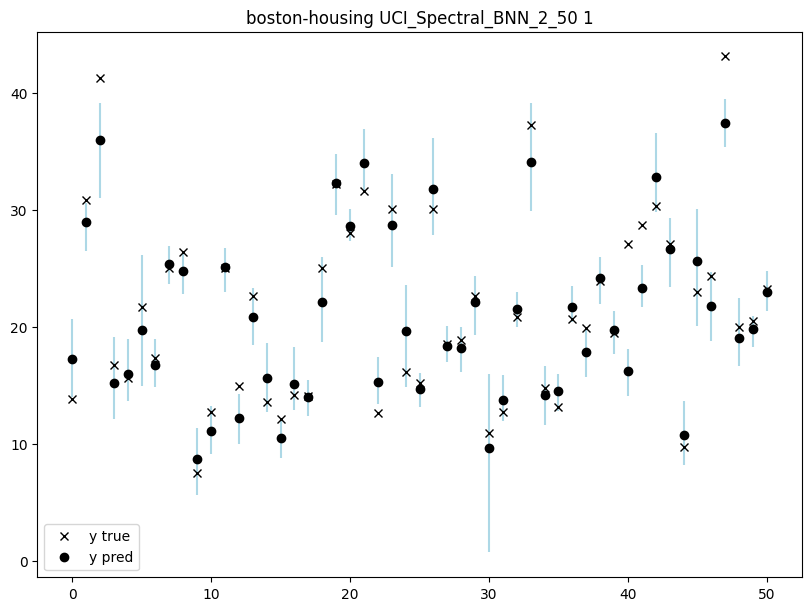

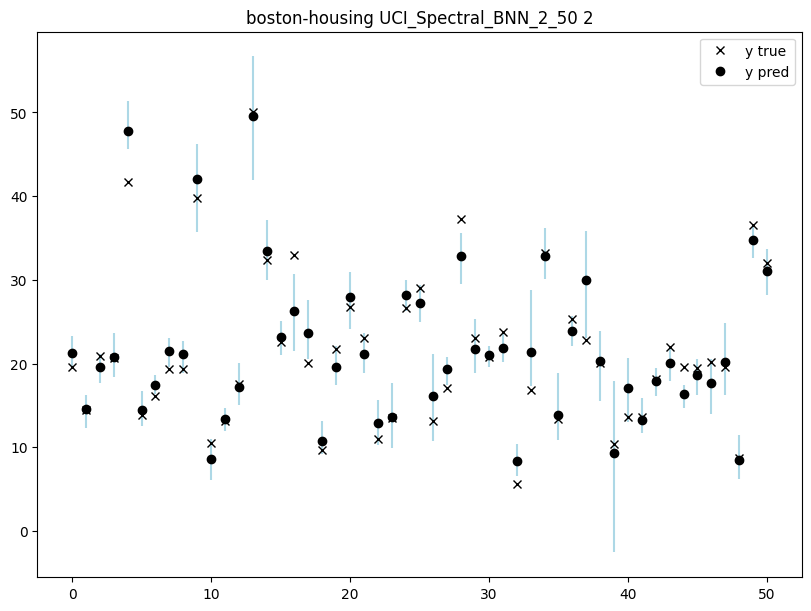

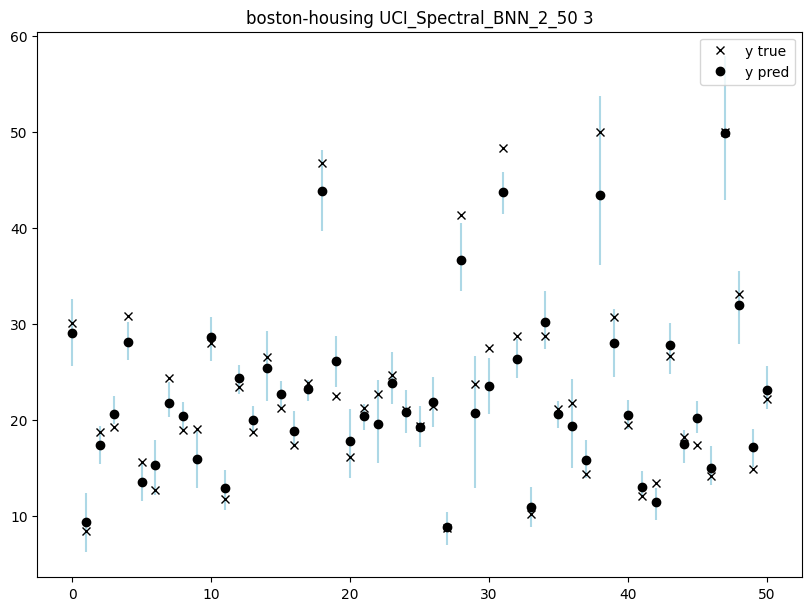

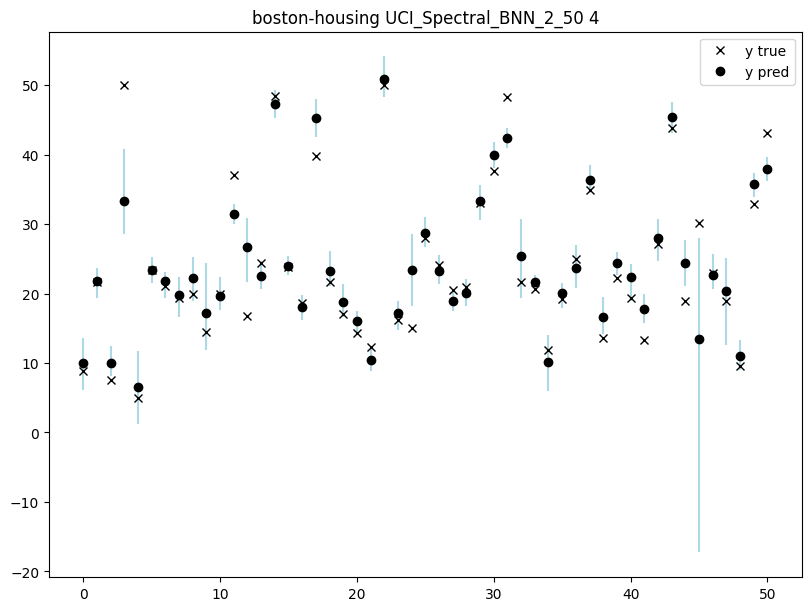

In [17]:
from matplotlib.collections import LineCollection
#fig, axs = plt.subplots(1, len(models), figsize=(8, 6*len(models)), constrained_layout=True)
#axs = axs.ravel()
for i, d in enumerate(models):
    dataset = UCIDataset(d["dataset"])
    split = load_standard_splits(True)[d["dataset"]][d["split"]]
    fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
    ax.set_title(f"{d['dataset']} {d['model']} {d['split']}")

    X = dataset.normalize_X(dataset.data[:, :-1], split)
    y = dataset.data[:, -1]

    train_X = X[split["tr"]]
    train_y = y[split["tr"]]
    test_X = X[split["te"]]
    test_y = y[split["te"]]

    predictive = Predictive(bnns.model_configs.__dict__[d["model"]], posterior_samples=d["samples"], return_sites=["y", "y_loc"], batch_ndims=2)
    key = jax.random.PRNGKey(SEED)
    predictive_ys = predictive(key, X=test_X, y=None, D_Y=1)["y_loc"]

    rmse = jnp.sqrt(jnp.mean((predictive_ys[0,:,:,0].mean(0) - test_y) ** 2))
    percentiles = np.percentile(predictive_ys[0,:,:,0], [5, 95], axis=0)
    ran = np.arange(predictive_ys.shape[1])
    ax.add_collection(
        LineCollection(
            zip(zip(ran, percentiles[0]), zip(ran, percentiles[1])), colors="lightblue"
        )
    )
    nll = -log_likelihood(bnns.model_configs.__dict__[d['model']], d['samples'], X=test_X, y=test_y, batch_ndims=2)['y'].mean()
    print(f"DATASET: {d['dataset']}, SPLIT: {d['split']}, NLL: {nll}, RMSE: {rmse}")
    ax.plot(test_y, "kx", label="y true")
    predictive_ys = predictive(key, X=test_X, y=None, D_Y=1)["y"]
    ax.plot(predictive_ys[0].mean(0)[:,0], "ko", label="y pred")
    ax.legend()


In [39]:
import dill
from numpyro import sample, plate, deterministic
from numpyro.distributions import Normal, Gamma
import numpyro.distributions as dist
from jax import nn

def BNN(X, y=None, depth=1, width=4, sigma=1.0, D_Y=None, activation=jnp.tanh):
    # Make sure D_Y is defined
    if y is None and D_Y is None:
        raise ValueError("Either y or D_Y must be provided.")
    if y is not None:
        if y.ndim == 1:
            y = y[..., None]
        D_Y = y.shape[-1]

    N = X.shape[-2]
    D_X = X.shape[-1]
    D_Z = width
    if depth == 1:
        D_Z = D_Y

    # First layer
    w = numpyro.sample("w0", dist.Normal(0.0, 1).expand((D_X, D_Z)))
    b = numpyro.sample("b0", dist.Normal(0.0, 1).expand((D_Z, )))
    z = X @ w + b.flatten()
    z_p = activation(z)

    # Middle layers:
    for i in range(1, depth):
        w = numpyro.sample(f"w{i}", dist.Normal(0.0, 1).expand((D_Z, D_Z)))
        b = numpyro.sample(f"b{i}", dist.Normal(0.0, 1).expand((D_Z,)))
        z = z_p @ w + b
        z_p = activation(z)

    # Last layer
    w = numpyro.sample(f"w{depth}", dist.Normal(0.0, 1).expand((D_Z,D_Y)))
    b = numpyro.sample(f"b{depth}", dist.Normal(0.0, 1).expand((D_Y,)))
    z = (z_p @ w + b).reshape(-1,1)
    if y is not None:
        assert z.shape == y.shape
    else:
        assert z.shape[-1] == D_Y
    with numpyro.plate("data", N):
        y_loc = deterministic("y_loc", z)
        numpyro.sample("y", dist.Normal(y_loc, sigma).to_event(1), obs=y)

def UCI_BNN(X, y=None, depth=2, width=50, D_Y=None):
    prec = numpyro.sample("prec", dist.Gamma(1.0, 0.1))
    _sigma = jnp.sqrt(1 / prec)
    BNN(X, y, depth=depth, width=width, D_Y=D_Y, sigma=_sigma, activation=nn.relu)

def smi_model(x, y):
    """BNN described in appendix D of [1]

    **References:**
        1. Understanding the Variance Collapse of SVGD in High Dimensions
           Jimmy Ba, Murat A. Erdogdu, Marzyeh Ghassemi, Shengyang Sun, Taiji Suzuki, Denny Wu, Tianzong Zhang
    """

    hdim = 50  # Hidden dimension is fixed

    prec = sample("prec", Gamma(1.0, 0.1))

    w1 = sample(
        "w1",
        Normal(0.0, 1).expand(
            (
                x.shape[1] if len(x.shape) > 1 else 1,
                hdim,
            )
        ),
    )  # prior on l1 weights
    b1 = sample("b1", Normal(0.0, 1).expand((hdim,)))  # prior on output bias term

    w2 = sample("w2", Normal(0.0, 1).expand((hdim, hdim)))  # prior on l1 weights
    b2 = sample("b2", Normal(0.0, 1).expand((hdim,)))  # prior on output bias term

    w3 = sample("w3", Normal(0.0, 1).expand((hdim,)))  # prior on output weights

    b3 = sample("b3", Normal(0.0, 1))  # prior on output bias term

    with plate(
        "data",
        x.shape[0],
    ) as idx:
        x_batch = x
        y_batch = y
        # 1 hidden layer with relu activation
        y_loc_p = nn.relu(nn.relu(x_batch @ w1 + b1) @ w2 + b2) @ w3 + b3
        y_loc = deterministic(
            "y_loc", y_loc_p
        )
        sample(
            "y",
            Normal(y_loc, jnp.sqrt(1 / prec)),
            obs=y_batch,
        )

smi_sample_path = "../samples/2025-02-12T15:31:49.515586"
model = lambda x, y: UCI_BNN(X=x, y=y, D_Y=1)
dataset = UCIDataset("boston-housing")
split = load_standard_splits(True)["boston-housing"][0]
with open(os.path.join(smi_sample_path, "boston-housing/bnn/nuts/none/artifact", "0.dill"), "rb") as f:
    artifact = dill.load(f)
samples = artifact["post_draws"]
X = dataset.normalize_X(dataset.data[:, :-1], split)
y = dataset.y
for i in range(3):
    samples[f"w{i}"] = samples.pop(f"w{i+1}")
    samples[f"b{i}"] = samples.pop(f"b{i+1}")

print("NLL ", -log_likelihood(model, samples, X[split["te"]], y[split["te"]], batch_ndims=2)["y"].mean())

def rmse_fn(posterior_samples, y, batch_ndims):
    """Compute the root mean squared error"""

    y_pred = posterior_samples["y_loc"]
    return jnp.sqrt(((y[None] - y_pred) ** 2).mean())

train_y_loc = samples.pop("y_loc", None)
assert train_y_loc is not None
predictive = Predictive(model, posterior_samples=samples, return_sites=["y", "y_loc"], batch_ndims=2)
key = jax.random.PRNGKey(SEED)
predicted_ys = predictive(key, X[split["te"]], None)["y_loc"]
rmse = rmse_fn({"y_loc": predicted_ys}, y[split["te"]], batch_ndims=2)
print("RMSE ", rmse)
# predictive = Predictive(model, posterior_samples=samples, return_sites=["y"], batch_ndims=2, parallel=True)
# pred_train_y = predictive(key, X=X[split["tr"]], y=None, D_Y=1)["y"]
# pred_test_y = predictive(key, X=X[split["te"]], y=None, D_Y=1)["y"]

NLL  16190.829
RMSE  10.491224


          model_name   key   ess-mean  ess-top-5  ess-bottom-5  rhat-mean  \
0  UCI_FFT_CBNN_2_50    b0  12.051931  21.453366      4.786142   1.205696   
1  UCI_FFT_CBNN_2_50    b1  21.503692  38.858752      9.465621   1.065397   
2  UCI_FFT_CBNN_2_50    b2  15.870585  15.870585     15.870585   1.093143   
3  UCI_FFT_CBNN_2_50  prec   6.192065   6.192065      6.192065   1.153682   
4  UCI_FFT_CBNN_2_50    w0  14.223204  29.366541      5.121427   1.143633   
5  UCI_FFT_CBNN_2_50    w1   8.158027  15.832812      3.393456   1.297287   
6  UCI_FFT_CBNN_2_50    w2  11.713706  30.924788      3.728744   1.237268   

   rhat-top-5  rhat-bottom-5  
0    1.698122       0.992827  
1    1.252463       0.991307  
2    1.093143       1.093143  
3    1.153682       1.153682  
4    1.571811       0.990629  
5    2.171012       0.993047  
6    1.834024       0.990644  
      model_name   key   ess-mean  ess-top-5  ess-bottom-5  rhat-mean  \
0  UCI_CBNN_2_50    b0  12.313058  22.972500      5.306839   1

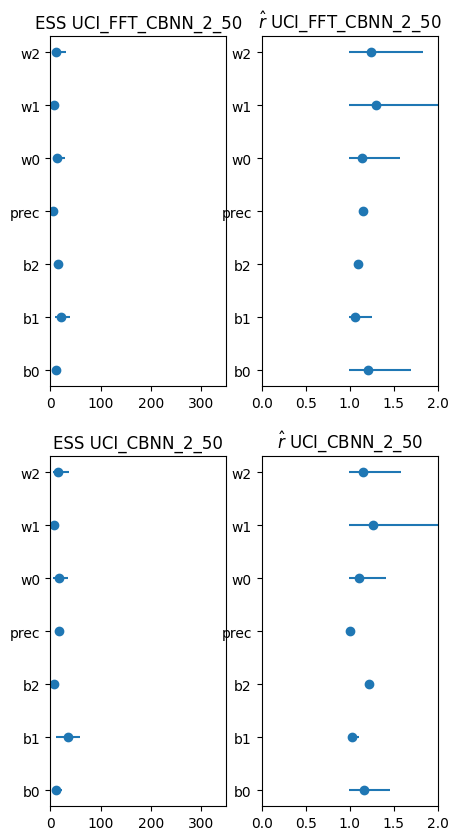

In [10]:
fig, axs = plt.subplots(nrows=len(models), ncols=2, figsize=(5, 5*len(models)))
for i, model in enumerate(models):
    az_data = model["az_data"]
    keys = model["samples"].keys()
    # ess = az.ess(az_data)
    data = []
    for key in keys:
        rhat = numpyro.diagnostics.split_gelman_rubin(model["samples"][key])
        ess = numpyro.diagnostics.effective_sample_size(model["samples"][key])
        data.append({
            "model_name": model["model"],
            "key": str(key),
            "ess-mean": ess.mean(),
            "ess-top-5": np.percentile(ess,95),
            "ess-bottom-5": np.percentile(ess,5),
            "rhat-mean": rhat.mean(),
            "rhat-top-5": np.percentile(rhat, 95),
            "rhat-bottom-5": np.percentile(rhat, 5),
        })
    df = pd.DataFrame(data)
    # axs[i, 0].plot(df["ess-mean"], df["key"], "ko", label="mean")
    axs[i, 0].errorbar(df["ess-mean"], df["key"], xerr=[df["ess-mean"] - df["ess-bottom-5"], df["ess-top-5"] - df["ess-mean"]], fmt="o")
    axs[i, 0].set_title(f"ESS {model["model"]}")
    axs[i, 0].set_xlim([0,350])

    # axs[i, 1].plot(df["rhat-mean"], df["key"], "ko", label="mean")
    axs[i, 1].set_xlim([0,2])
    axs[i, 1].errorbar(df["rhat-mean"], df["key"], xerr=[df["rhat-mean"] - df["rhat-bottom-5"], df["rhat-top-5"] - df["rhat-mean"]], fmt="o")
    axs[i, 1].set_title(f"{r"$\hat{r}$"} {model["model"]}")
    print(df)
#sns.lineplot(data=df, x="mean", y="key", hue="model_name", dodge=True)



In [105]:
ess.data_vars["b0"].mean()

<xarray.DataArray 'b0' ()> Size: 8B
array(20.32781263)

{'model': None,
 'guide': None,
 'params': None,
 'hyper_params': {'lr': None},
 'post_draws': {'prec': Array([[0.47007948, 0.47976005, 0.47588268, ..., 0.42138174, 0.42835027,
          0.42088836]], dtype=float32),
  'y_loc': Array([[[30.557629 , 23.540201 , 16.544842 , ..., 19.854206 ,
           13.306897 , 22.948927 ],
          [27.71121  , 24.874876 , 17.373001 , ..., 20.129562 ,
           13.991251 , 21.442116 ],
          [29.588762 , 25.360512 , 18.586535 , ..., 20.604664 ,
           13.444028 , 21.29989  ],
          ...,
          [27.948448 , 24.540367 , 19.078539 , ..., 19.65227  ,
           13.37832  , 21.840698 ],
          [29.802168 , 24.389034 , 20.482634 , ..., 19.19399  ,
           13.1453085, 22.23238  ],
          [30.339603 , 24.072792 , 19.382608 , ..., 19.739878 ,
           14.361593 , 22.001156 ]]], dtype=float32),
  'w0': Array([[[[-1.4972149 , -0.240414  , -1.3065985 , ...,  1.0526959 ,
             0.41472426, -1.2383453 ],
           [ 0.28218284,  0

# MCMC diagnostics

## Load metadata

In [11]:
from jax.numpy import float32, int32 , array as Array
import dill
metadatas = []
for dataset_name in os.listdir(SAMPLE_PATH):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    if dataset_name in dataset_names:
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))):
            if file_name[-13:] == "metadata.dill":
                with open(os.path.join(SAMPLE_PATH, dataset_name, file_name), "rb") as f:
                    metadatas.append(dill.load(f))
metadatas

[{'accept_prob': Array([0.70137155, 0.8473585 , 0.6296817 , 0.8285232 , 0.52217454,
         0.4728051 , 0.9203443 , 0.9347981 , 0.8453467 , 0.9167628 ,
         0.66307276, 0.99957395, 0.96454936, 0.8794318 , 0.97177476,
         0.8498323 , 0.94290584, 0.5613212 , 0.95782226, 0.73588824,
         0.4502724 , 0.98605305, 0.9945368 , 0.89122164, 0.927898  ,
         0.98112166, 0.7047082 , 0.8931654 , 0.9042981 , 0.90679854,
         0.92203194, 0.9789038 , 0.9364866 , 0.80228245, 0.54777586,
         0.9496537 , 0.9604361 , 0.9231218 , 0.7594067 , 0.9978006 ,
         0.9981848 , 0.9686976 , 0.59600484, 0.9981059 , 0.7565586 ,
         0.9077806 , 0.8559679 , 0.9405323 , 0.8872966 , 0.9588449 ,
         0.9116816 , 0.9582425 , 0.92318225, 0.7000911 , 0.97630453,
         0.8865386 , 0.7572678 , 0.9467629 , 0.92078   , 0.6706086 ,
         0.95757484, 0.67371315, 0.8283383 , 1.        , 0.87685394,
         0.6303517 , 0.8845076 , 0.8168419 , 0.92428285, 0.90787536,
         0.84933865

# Acceptance probability

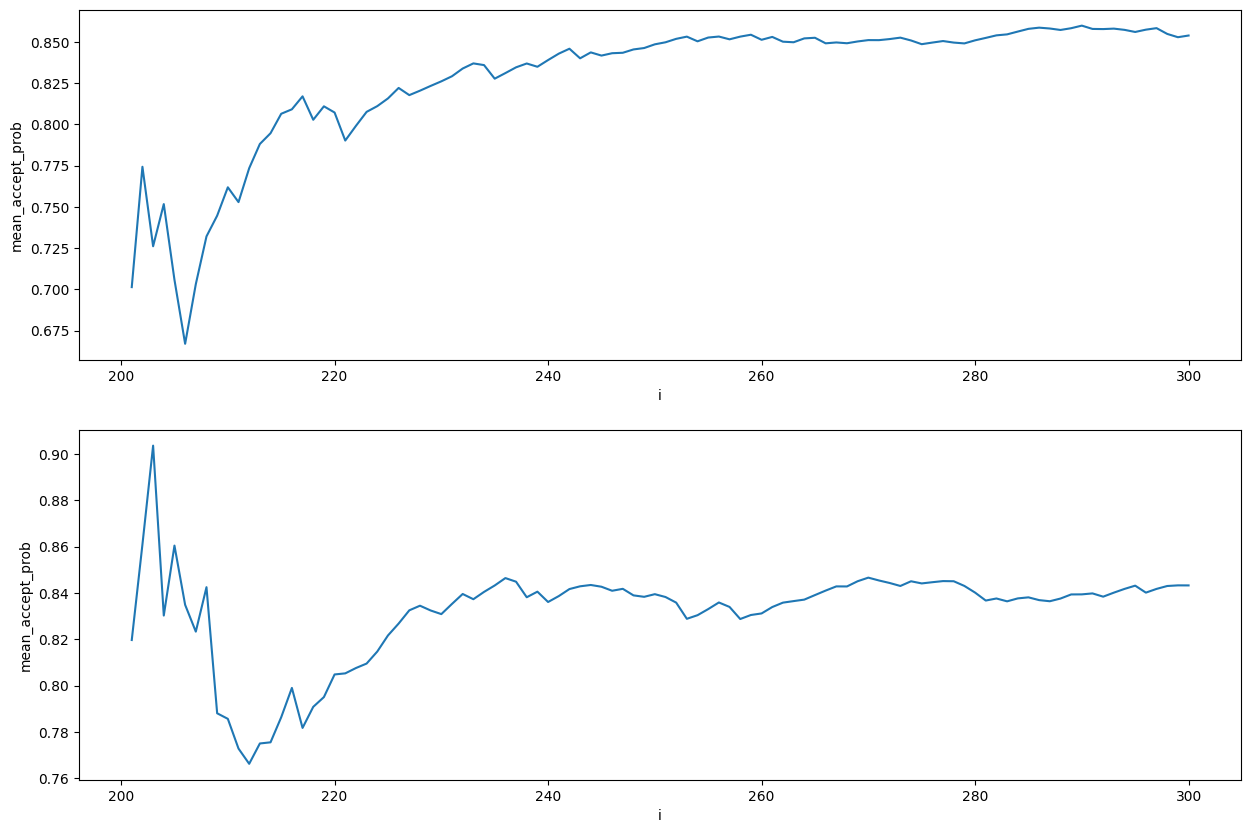

In [12]:
import seaborn as sns
fig, axs = plt.subplots(len(metadatas), 1, figsize=(15, 5*len(metadatas)))
axs = np.array([axs]) if len(metadatas) == 1 else axs
for metadata, ax in zip(metadatas, axs):
    data = pd.DataFrame(metadata)
    sns.lineplot(data=data, x="i", y="mean_accept_prob", ax=ax)

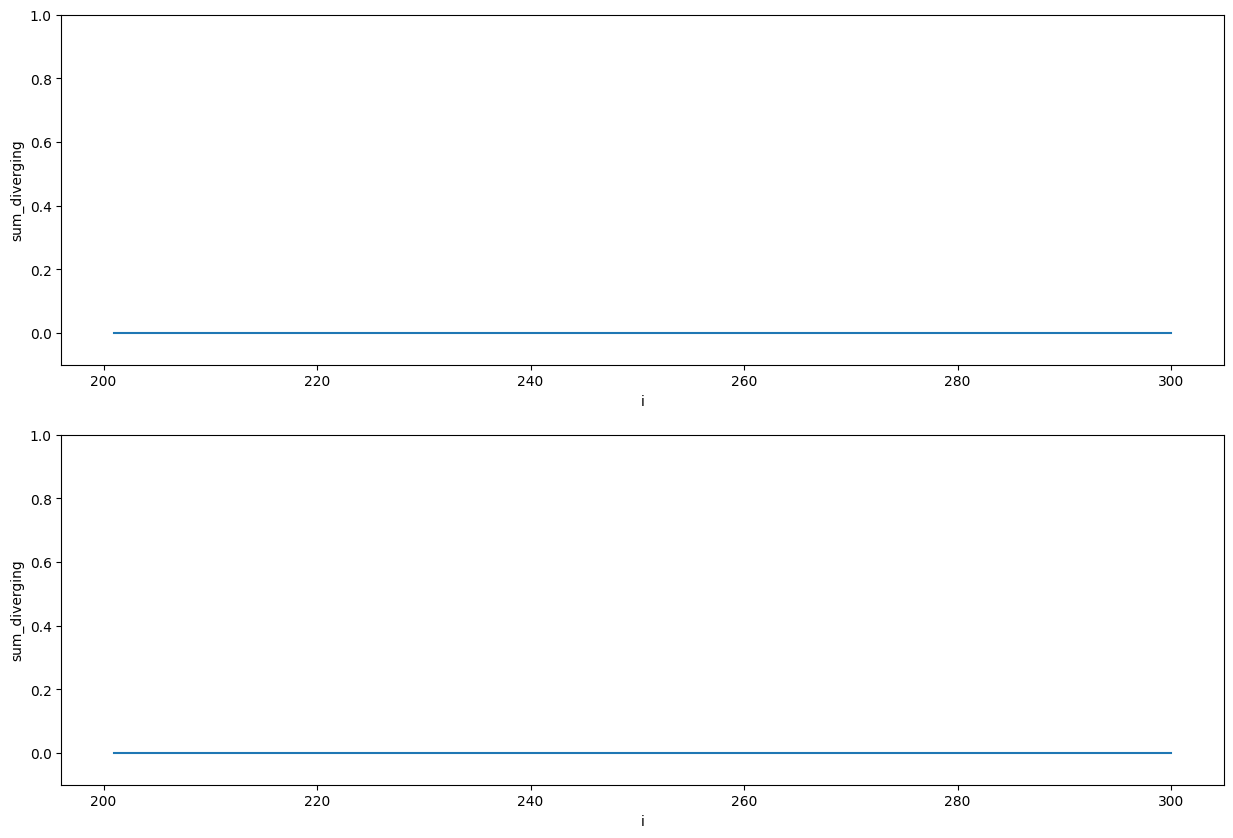

In [13]:
fig, axs = plt.subplots(len(metadatas), 1, figsize=(15, 5*len(metadatas)))
axs = np.array([axs]) if len(metadatas) == 1 else axs
for metadata, ax in zip(metadatas, axs):
    data = pd.DataFrame(metadata)
    data["sum_diverging"] = data["diverging"].cumsum()
    sns.lineplot(data=data, x="i", y="sum_diverging", ax=ax)
    ax.set_ylim([-0.1,1])

<Axes: xlabel='model_name', ylabel='time_spanned'>

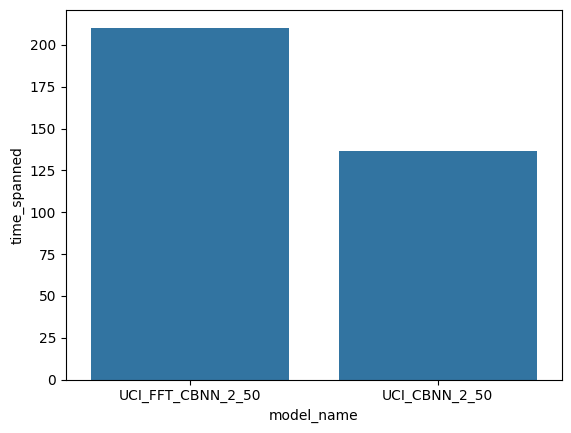

In [14]:
total_df = []
for i, metadata in enumerate(metadatas):
    metadata["model_name"] = models[i]["model"]
    total_df.append(metadata)
total_df = pd.DataFrame(total_df)
sns.barplot(data=total_df, x="model_name", y="time_spanned")

<Axes: xlabel='model', ylabel='prec'>

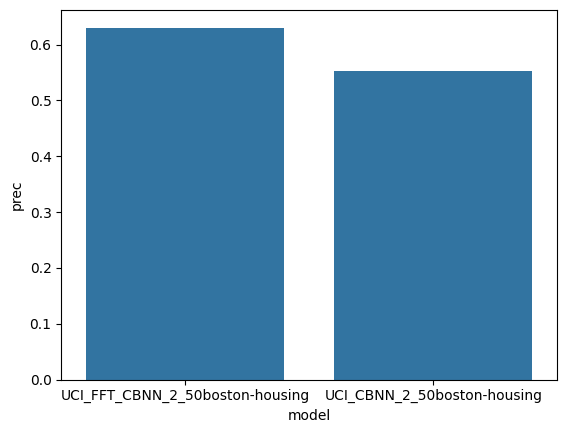

In [15]:
total_df = []
for model in models:
    total_df.append({"model": model["model"] + model["dataset"], "prec": model["samples"]["prec"].mean()})

sns.barplot(data=pd.DataFrame(total_df), x="model", y="prec")

In [15]:
jnp.sqrt(1/0.5)

Array(1.4142135, dtype=float32, weak_type=True)

# Precision prior vs posterior

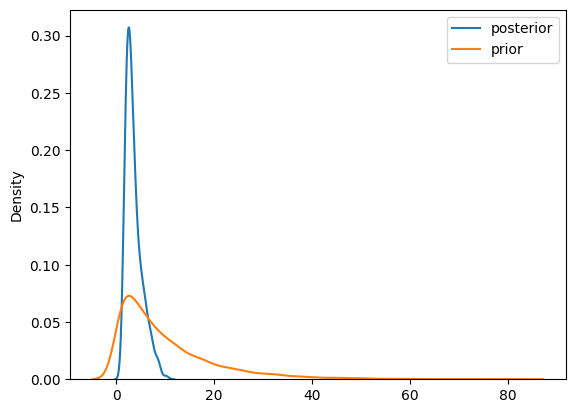

In [26]:
sns.kdeplot(data=d["samples"]["prec"].flatten(), label="posterior")
sns.kdeplot(jax.random.gamma(jax.random.PRNGKey(SEED), 1.0, (10000,))/0.1, label="prior")
plt.legend()